# Part IV (Dynamic Hedging)
Suppose $S_0=100$, $\sigma=0.2$, $r=5\%$, $T=\frac{1}{12}$ year, i.e. 1 month, and $K=100$. Use the Black-Scholes model to simulate the stock price. Suppose we sell this at-the-money call option, and we hedge $N$ times during the life of the call option. Assume there are 21 trading days over the month. The dynamic hedging strategy for an option is $C_t=\phi_tS_t-\psi_tB_t$, where $\phi_t=\frac{\partial C}{\partial S}=\Phi\left(\frac{\log\left(\frac{S_t}{K}\right)+\left(r+\frac{1}{2}\sigma^2\right)(T-t)}{\sigma\sqrt{T-t}}\right)$, and $\psi_tB_t=-Ke^{-r(T-t)}\Phi\left(\frac{\log\left(\frac{S_t}{K}\right)+\left(r-\frac{1}{2}\sigma^2\right)(T-t)}{\sigma\sqrt{T-t}}\right)$.

# Response
Let us start by defining these stock and bond holding functions:

In [3]:
from scipy.stats import norm
import numpy as np
import matplotlib.pylab as plt

def phi(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)

def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return -K*np.exp(-r*T)*norm.cdf(d2)

def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)

Next, we shall simulate a single stock price process under the Black-Scholes dynamics, and follow the delta, stock and bond holdings over time until maturity.

We first generate a million-path stock price process, and then apply this to a call option struck at 100, and today's stock price is also 100. The maturity date is 1 month later, and volatility is 20%.

/var/folders/k1/7yl62fwx2879_758cjywcjrw0000gn/T/ipykernel_37580/1385764260.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
/var/folders/k1/7yl62fwx2879_758cjywcjrw0000gn/T/ipykernel_37580/1385764260.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))


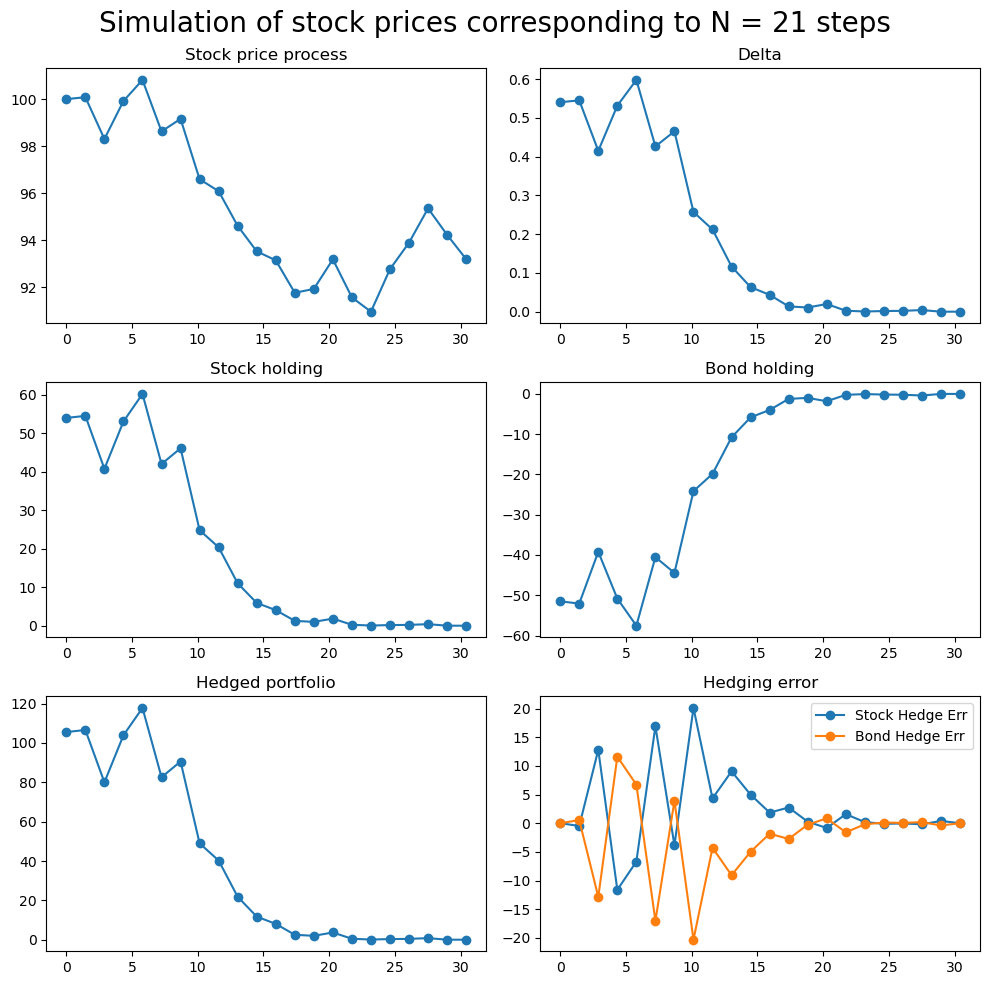

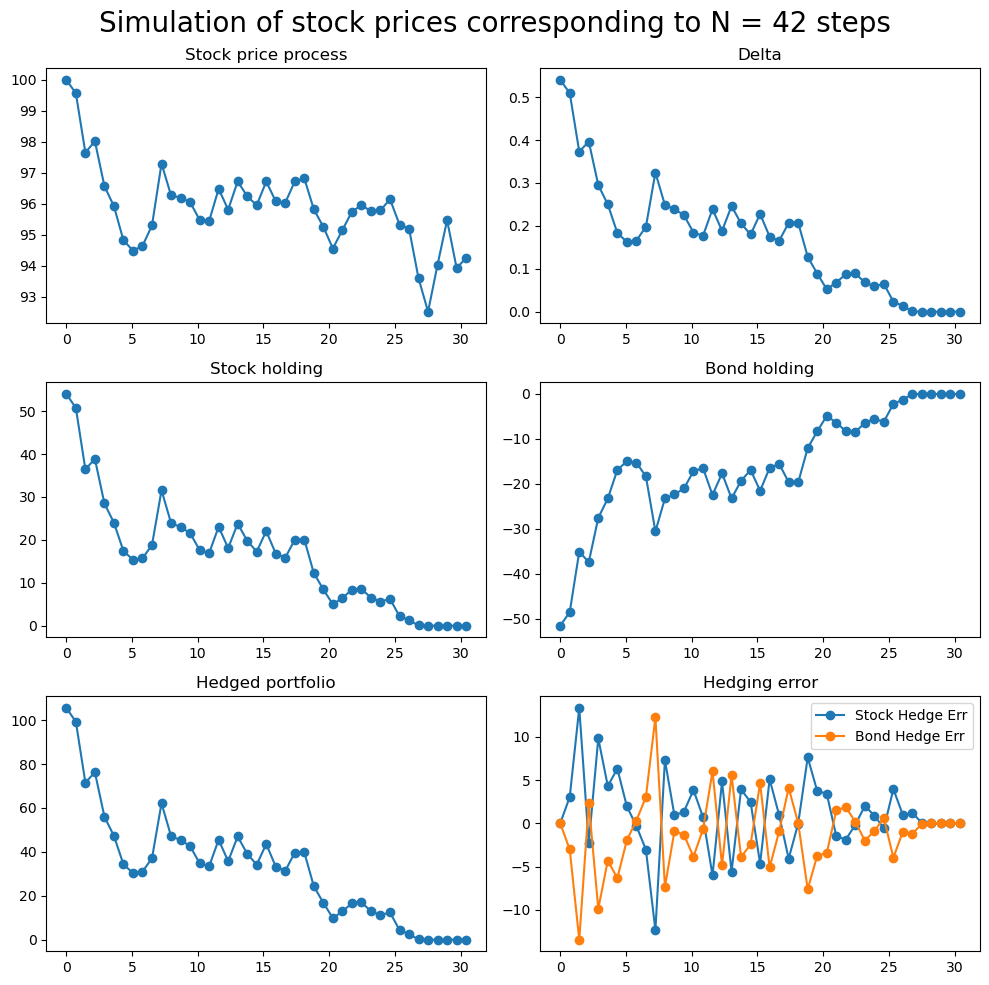

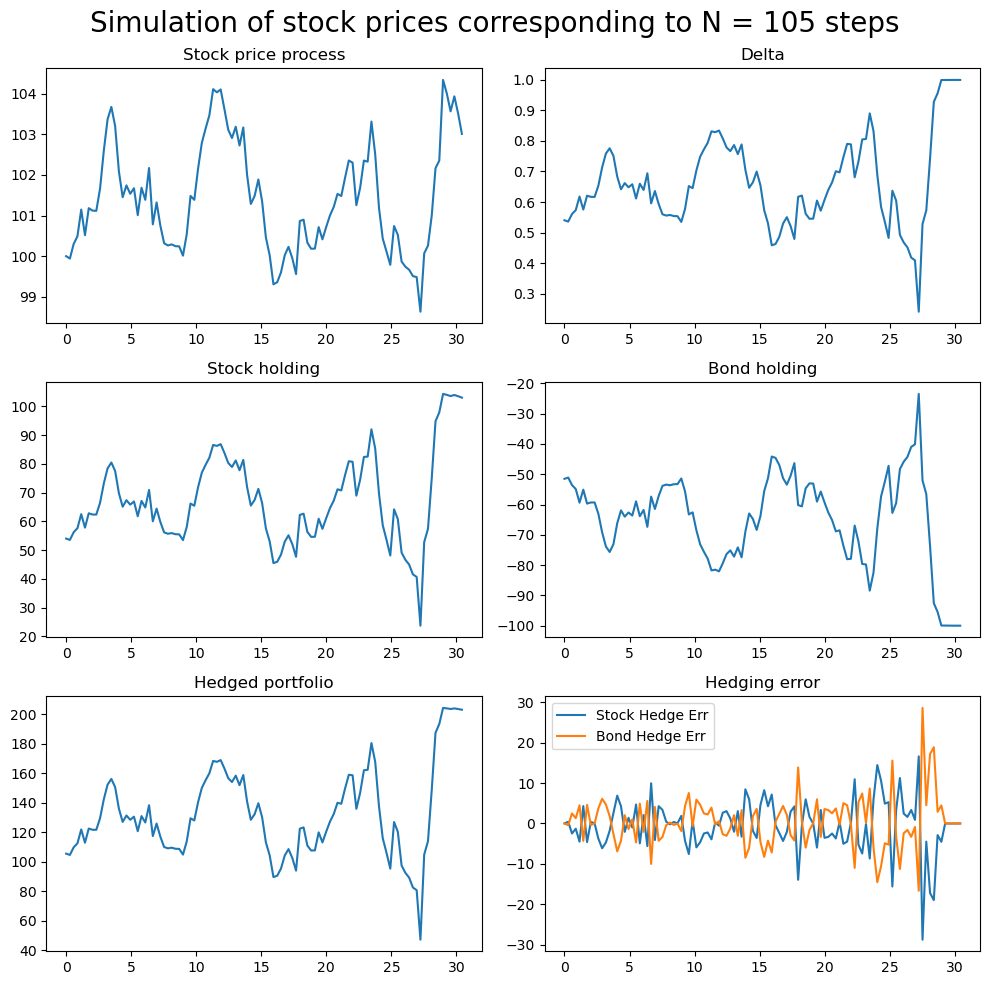

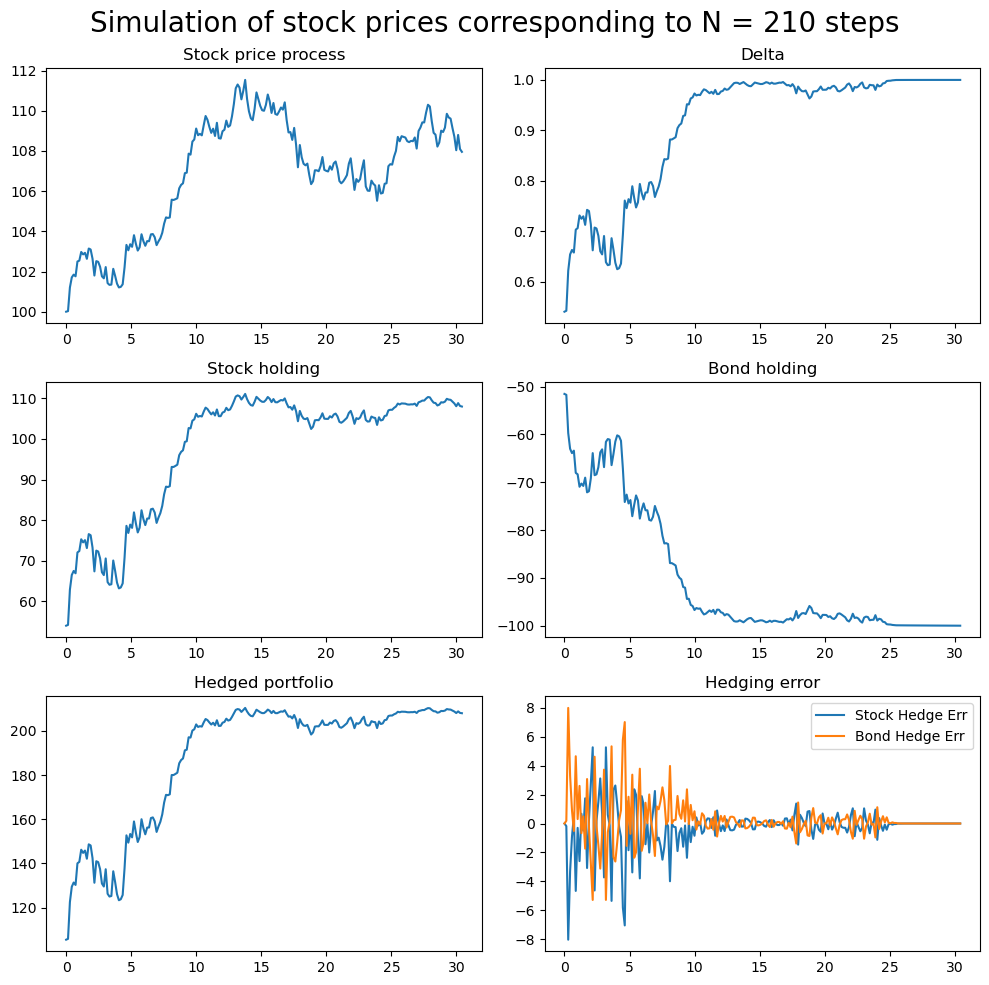

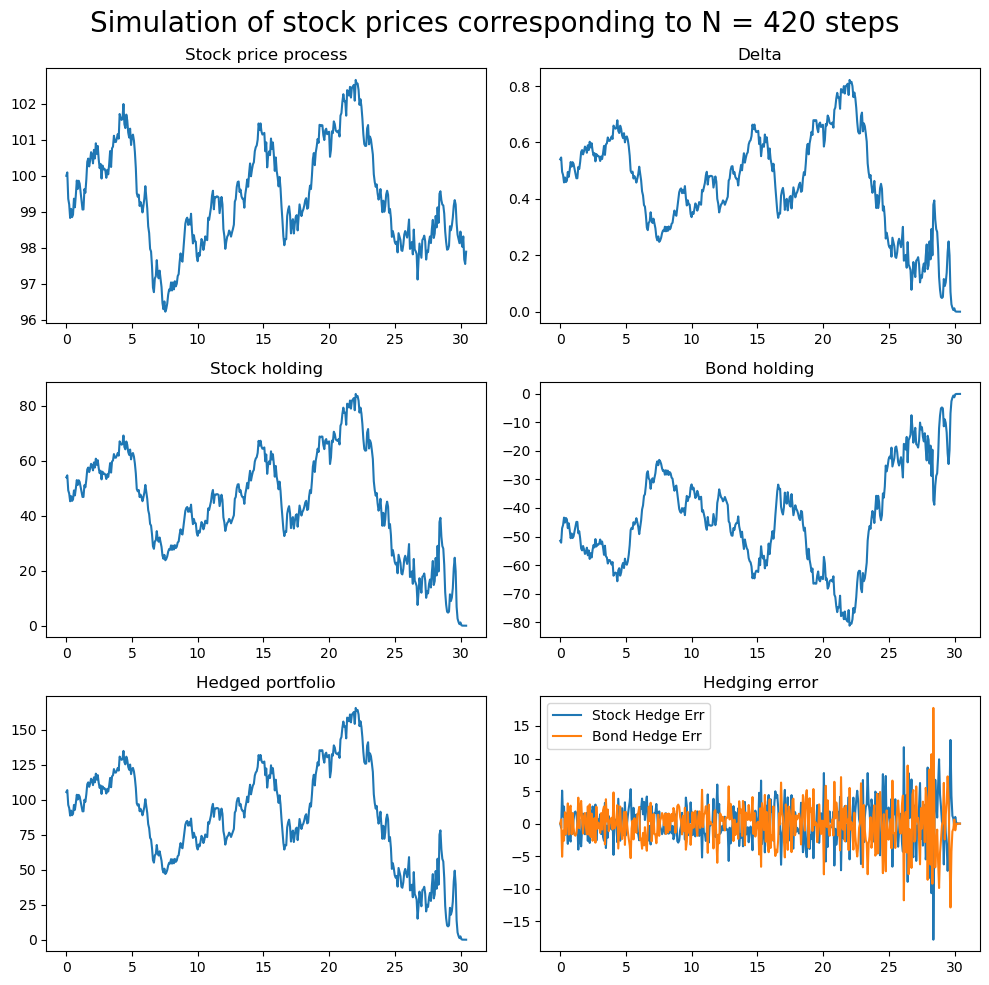

In [5]:
r = 0.05
S0 = 100
K = 100
sigma = 0.2
maturity = 1/12
paths = 1000000

list_N = [21, 42, 105, 210, 420] # the list of the sample numbers of steps, N, that we are considering in this simulation

for steps in list_N:    
    T, W_T = simulate_Brownian_Motion(paths, steps, maturity)

    dt = maturity / steps
    blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0])

    deltas = []
    stockhedge_errors = []
    bondhedge_errors = []
    hedged_portfolios = []
    stock_holdings = []
    bond_holdings = []
    for t, S_t in zip(T, blackscholespath):
        stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
        bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
        C_t = stock_pos - bond_pos
        stock_holdings.append(stock_pos)
        bond_holdings.append(bond_pos)
        hedged_portfolios.append(C_t)
        deltas.append(phi(S_t, K, r, sigma, maturity-t))
        if t == 0.0:
            stockhedge_errors.append(0)
            bondhedge_errors.append(0)
        else:
            stockhedge_errors.append(prev_phi*S_t - stock_pos)
            bondhedge_errors.append(prev_bond_pos*np.exp(r*dt) - bond_pos)
    
        prev_phi = phi(S_t, K, r, sigma, maturity-t)
        prev_bond_pos = bond_pos
    
    if steps <= 60:
        plt.figure(tight_layout=True, figsize=(10, 10))
        plt.subplot(321)
        plt.plot(T * 365, blackscholespath, linestyle='-', marker='o')
        plt.title('Stock price process')
        plt.subplot(322)
        plt.plot(T * 365, deltas, linestyle='-', marker='o')
        plt.title('Delta')
        plt.subplot(323)
        plt.plot(T * 365, stock_holdings, linestyle='-', marker='o')
        plt.title('Stock holding')
        plt.subplot(324)
        plt.plot(T * 365, bond_holdings, linestyle='-', marker='o')
        plt.title('Bond holding')
        plt.subplot(325)
        plt.plot(T * 365, hedged_portfolios, linestyle='-', marker='o')
        plt.title('Hedged portfolio')
        plt.subplot(326)
        plt.plot(T * 365, stockhedge_errors, label='Stock Hedge Err', linestyle='-', marker='o')
        plt.plot(T * 365, bondhedge_errors, label='Bond Hedge Err', linestyle='-', marker='o')
        plt.legend()
        plt.title('Hedging error')
        plt.suptitle(f"Simulation of stock prices corresponding to N = {steps} steps", fontsize = 20)
        plt.show()
    else:
        plt.figure(tight_layout=True, figsize=(10, 10))
        plt.subplot(321)
        plt.plot(T * 365, blackscholespath, linestyle='-')
        plt.title('Stock price process')
        plt.subplot(322)
        plt.plot(T * 365, deltas, linestyle='-')
        plt.title('Delta')
        plt.subplot(323)
        plt.plot(T * 365, stock_holdings, linestyle='-')
        plt.title('Stock holding')
        plt.subplot(324)
        plt.plot(T * 365, bond_holdings, linestyle='-')
        plt.title('Bond holding')
        plt.subplot(325)
        plt.plot(T * 365, hedged_portfolios, linestyle='-')
        plt.title('Hedged portfolio')
        plt.subplot(326)
        plt.plot(T * 365, stockhedge_errors, label='Stock Hedge Err', linestyle='-')
        plt.plot(T * 365, bondhedge_errors, label='Bond Hedge Err', linestyle='-')
        plt.legend()
        plt.title('Hedging error')
        plt.suptitle(f"Simulation of stock prices corresponding to N = {steps} steps", fontsize = 20)
        plt.show()